### import numpy as np
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})

import scipy.linalg as spl
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
import xarray as xr

from waveeqn1D import WaveEquation

from utils import *
import nfft
import time

# Solving for the 1D, variable speed wave equation by Fourier transforming in time

We seek to solve the variable speed, 1D wave equation: $\dfrac{\partial^2 \eta}{\partial t^2} = \dfrac{\partial}{\partial x} \left(c^2 \dfrac{\partial  \eta}{\partial x} \right)$.

For a single Fourier mode $\eta(x,t) = \tilde\eta(x) e^{-i\omega t}$, the wave equation for is $$\dfrac{\mathrm{d}}{\mathrm{d}x}\left(c(x)^2\dfrac{\mathrm{d}\tilde\eta}{\mathrm{d}x}\right) + \omega^2\tilde\eta = 0 $$

With Dirichlet BCs, the mode equation admits discrete eigenmodes $(\omega_n, \tilde\eta_n(x))$. The full solution can be written as a combination of these modes, traveling in both directions:
$$\eta(x,t) = \sum_n \alpha_{n+}\tilde\eta_n(x)e^{i\omega_n t} + \alpha_{n-}\tilde\eta_n(x)e^{-i\omega_n t}$$
The $\alpha_{n+}$ and $\alpha_{n-}$ coefficients are found with the initial conditions $\eta(x,0) = \eta_0(x)$ and $\dfrac{\partial \eta}{\partial t}(x,0) = 0$, which lead to a system of size $2N\times 2N$, where $N$ is the size of the spatial grid.

In [2]:
#Define the initial condition eta(t=0) and velocity profile c(x)
def modulation(x,x0=10e3,halfwidth=1e3):
    return 1-np.exp(-(x-x0)**2/2/halfwidth**2)/3
x_initial = 20e3 #position of the initial perturbation
initial = lambda x: -100*np.exp(-(x-x_initial)**2/2/0.5e3**2) #Set the initial perturbation (function of x)
celer = lambda x: 2.67*modulation(x,30e3,2e3) #Set the spatial profile of wave speed (function of x)

In [11]:
%%time
## Ground truth - finite difference method
wave = WaveEquation(1,1,Lx=100e3,dx=100e3/1400,Lt=10*3600)
wave.I = initial
wave.celer   = celer  
wave.integrate()

eta_fd = xr.DataArray(wave.U,coords={'x':wave.X,'time':wave.T},dims=['x','time'])

CPU times: user 2.85 s, sys: 445 ms, total: 3.3 s
Wall time: 3.73 s


In [4]:
class WaveEquationNFourier:
    def __init__(self,Lx=1.5,Nx=100,Lt=3600,Nt=60):
        #Spatial mesh
        self.L_x = Lx #Range of the domain according to x [m]
        self.N_x = Nx #Points number of the spatial mesh
        self.X = np.linspace(0,self.L_x,self.N_x)
        self.dx = self.X[1]-self.X[0] #Infinitesimal distance
        
        #Temporal mesh 
        self.L_t = Lt 
        self.N_t = Nt #Points number of the temporal mesh
        self.T = np.linspace(0,self.L_t,self.N_t)
        self.dt = self.T[1]-self.T[0] #Infinitesimal time

    def set_eigenmodes(self):
        """Compute the eigenmodes eta_tilde_n and associated eigenvalues"""
        D1 = make_D_fornberg(self.X,1,npoints=5)
        A = np.dot(D1,self.celer(self.X)**2*D1)
        A[0]=0.;A[0,0]=1.
        A[-1]=0.;A[-1,-1]=1.
        
        minusomegas2,etatildes=spl.eig(A) # The eigenvalues correspond to -omega^2, where omega is the eigenfrequency of each mode
        sortidx = np.argsort(minusomegas2)
        cutoff=-2 # Throw away non-oscillatory modes
        omegas2 = -np.real(minusomegas2[sortidx[:cutoff]])
        etatildes = etatildes[:,sortidx[:cutoff]]
        
        self.omegas = np.sqrt(omegas2) # Vector of size N_x-2
        self.eta_omegas = etatildes # Matrix of shape (N_x,N_x-2)

    def set_initcond_matrix(self):
        """Setup the matrix that maps mode coefficients to initial condition and initial time derivative"""
        #M is of size (2*(N_x-2),2*(N_x-2)) (there are N_x-2 modes and N_x-2 grid points excluding bounds; double this because there are rightward-traveling and leftward-traveling components)
        self.M = np.block([[self.eta_omegas[1:-1],self.eta_omegas[1:-1]],[-1j*self.omegas[None,:]*self.eta_omegas[1:-1],1j*self.omegas[None,:]*self.eta_omegas[1:-1]]])
    
    def set_initcond_rhs(self):
        """Setup the right-hand side of the initial condition equation (eta(t=0) set by self.I and deta/dt(t=0)=0)"""
        self.rhs = np.concatenate((self.I(self.X)[1:-1],np.zeros(self.N_x-2)))
        
    def integrate(self):
        t=time.time()
        self.set_eigenmodes()
        self.set_initcond_matrix()
        self.set_initcond_rhs()
        # Get mode coefficients
        alphas = spl.solve(self.M,self.rhs)

        # define evaluation points for the nonuniform inverse fft
        fk = self.omegas*self.dt/2/np.pi        

        eta1 = 1j*np.zeros((len(self.eta_omegas),self.N_t))
        # Perform the nonuniform inverse fft, grid point by grid point
        for ix in range(len(self.eta_omegas)):
            eta1[ix] =  nfft.nfft_adjoint(-fk, alphas[:len(self.omegas)]*self.eta_omegas[ix,:]*np.exp(-2*np.pi*1j*(self.N_t//2)*fk), self.N_t)
            eta1[ix] += nfft.nfft_adjoint( fk, alphas[len(self.omegas):]*self.eta_omegas[ix,:]*np.exp(2*np.pi*1j*(self.N_t//2)*fk), self.N_t)
        self.eta=np.real(eta1)
        print("%.2f"%(time.time()-t))
        
        #Inverse FT by hand
        #self.eta = (alphas[None,:nmodes,None]*self.eta_omegas[:,:nmodes,None]*np.exp(-1j*self.omegas[None,:nmodes,None]*self.T[None,None,:])\
        #           +alphas[None,len(self.omegas):len(self.omegas)+nmodes,None]*self.eta_omegas[:,:nmodes,None]*np.exp(1j*self.omegas[None,:nmodes,None]*self.T[None,None,:])\
        #           ).sum(axis=1)



In [5]:
%%time
wave_nfft = WaveEquationNFourier(Lx=100e3,Nx=1200,Lt=10*3600,Nt=3600)
wave_nfft.I = initial
wave_nfft.celer   = celer  
wave_nfft.integrate()
eta_nfft = xr.DataArray(wave_nfft.eta,coords={'x':wave_nfft.X,'time':wave_nfft.T},dims=['x','time'])

10.00
CPU times: user 16.7 s, sys: 793 ms, total: 17.5 s
Wall time: 10 s


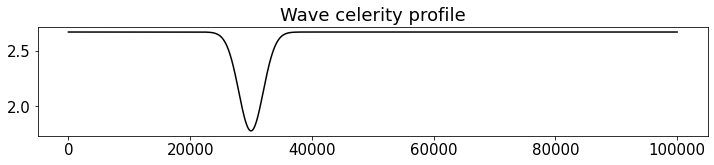

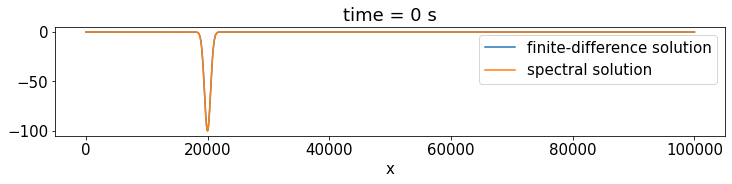

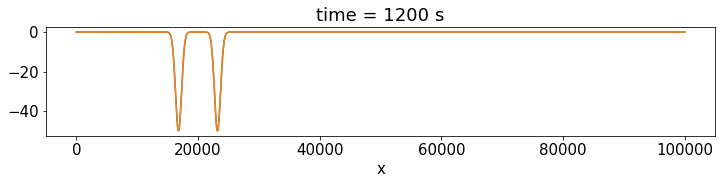

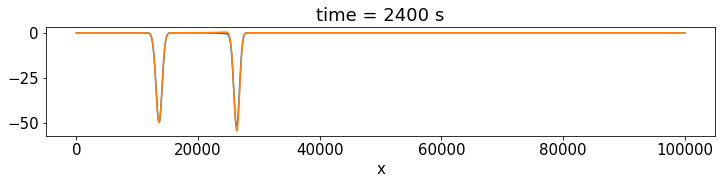

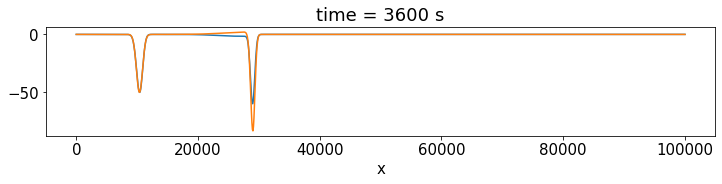

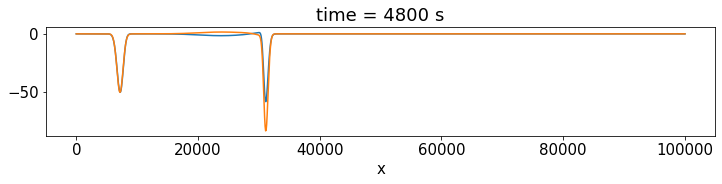

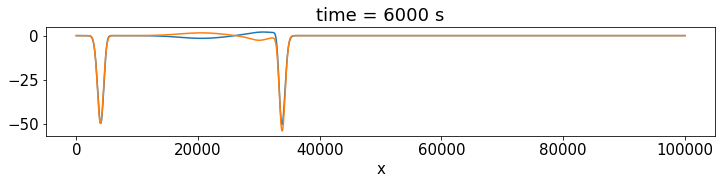

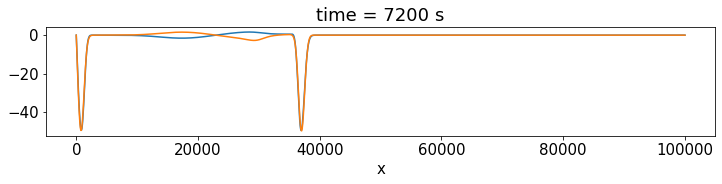

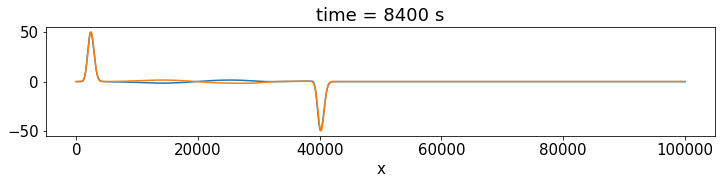

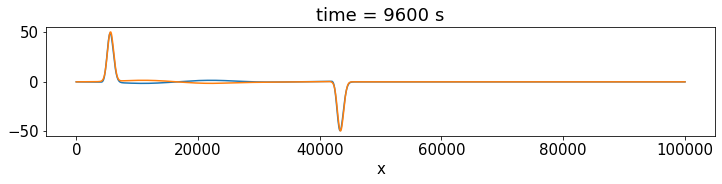

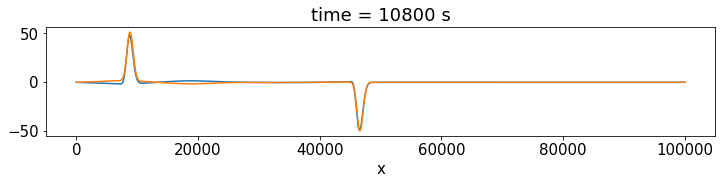

In [26]:
plt.figure(figsize=(12,2))
plt.plot(wave.X,wave.celer(wave.X),color='k');plt.title("Wave celerity profile")
for t in np.arange(0,12000,1200):
    plt.figure(figsize=(12,2))
    eta_fd.sel(time=t,method='nearest').plot(label='finite-difference solution')
    eta_nfft.sel(time=t,method='nearest').plot(label='spectral solution')
    plt.title("time = %i s"%t)
    if t==0:
        plt.legend()

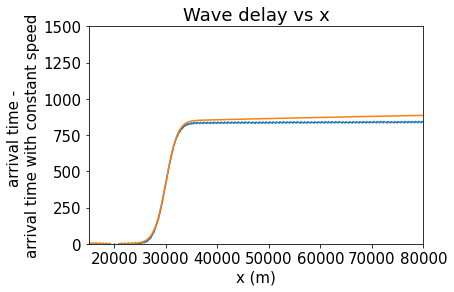

In [28]:
def dtime(x,eta,dt):
    return eta.argmin(axis=1)*dt-np.abs((x-20e3)/2.67)

plt.plot(wave_nfft.X,dtime(wave_nfft.X,wave_nfft.eta,wave_nfft.dt))
plt.plot(wave.X,dtime(wave.X,wave.U,wave.dt))

plt.xlim(15000,80000)
plt.ylim(0,1500)
plt.xlabel("x (m)")
plt.ylabel("arrival time - \narrival time with constant speed")
plt.title("Wave delay vs x");None